# Libraries

In [28]:
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
from os import listdir

from PIL import Image
from sklearn import metrics
import tensorflow as tf

# Import dataset

In [29]:
path = '/content/drive/MyDrive/DATASET/Images /archive - 2024-11-07T201235.258/data'
print('List dir:')
for file in os.listdir(path):
  print(file)

List dir:
validation
train


In [30]:
DIR_TRAIN = os.path.join(path, 'train')
DIR_TEST = os.path.join(path, 'validation')

In [31]:
dir_train_alien = os.path.join(DIR_TRAIN, 'alien')
dir_train_predator = os.path.join(DIR_TRAIN, 'predator')
dir_val_alien = os.path.join(DIR_TEST, 'alien')
dir_val_predator = os.path.join(DIR_TEST, 'predator')

# Image Visualization

In [32]:
def display_images(image_dir, title, num_images=9):
  img_files = os.listdir(image_dir)[:num_images]
  fig, axes = plt.subplots(3, 3, figsize=(9, 9))
  axes = axes.flatten()

  for i, img_file in enumerate(img_files):
    image_path = os.path.join(image_dir, img_file)
    try:
      img = Image.open(image_path)
      axes[i].imshow(img)
      axes[i].axis('off')
    except Exception as e:
      print(f"Error opening {image_path}: {e}")

  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

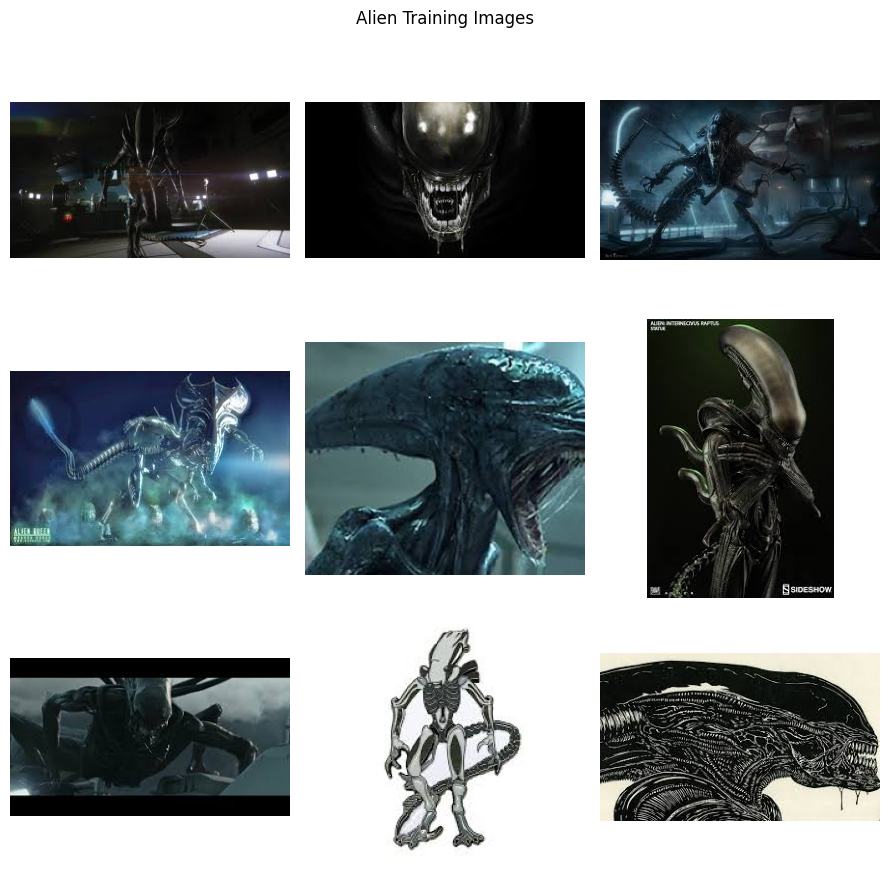

In [33]:
display_images(dir_train_alien, 'Alien Training Images')

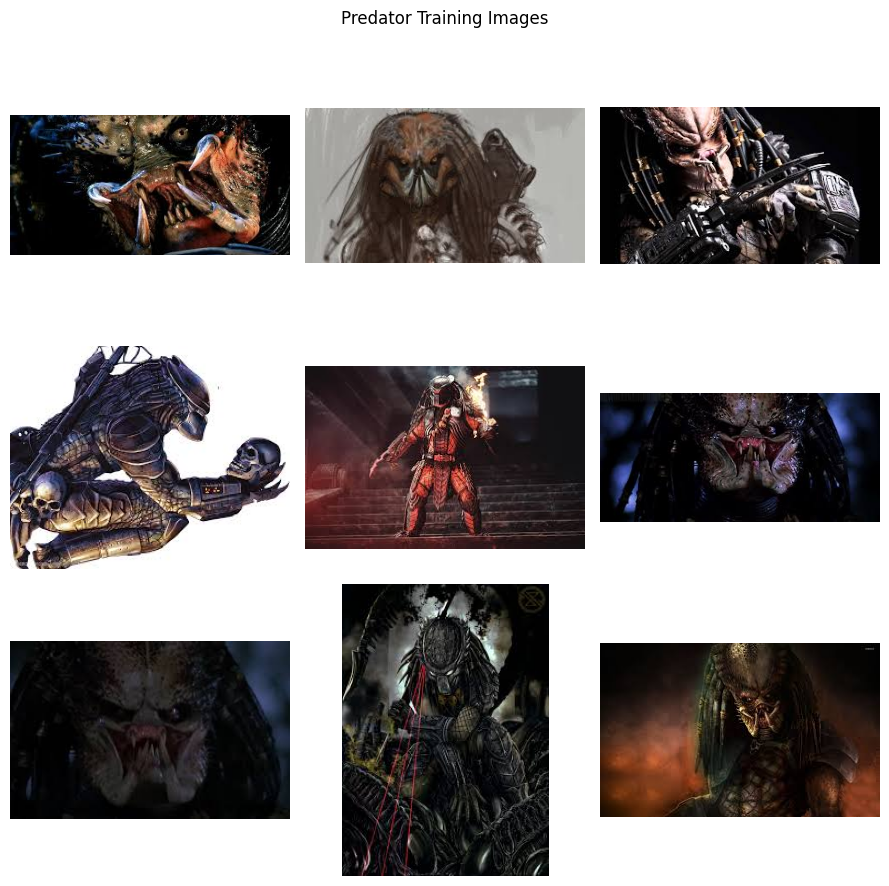

In [34]:
display_images(dir_train_predator, 'Predator Training Images')

# Train Val Dataset

In [35]:
def train_val_dataset():
  training_dataset = tf.keras.utils.image_dataset_from_directory(
      directory = DIR_TRAIN,
      batch_size = 32,
      image_size=(120,120),
      shuffle=True,
      seed=7
  )

  validation_dataset = tf.keras.utils.image_dataset_from_directory(
      directory=DIR_TEST,
      batch_size=32,
      image_size=(120,120),
      shuffle=32,
      seed=7
  )

  return training_dataset, validation_dataset

In [36]:
training_dataset, validation_dataset = train_val_dataset()

Found 704 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


## Data Augmentation

In [37]:
def augmentation():
    augmentation_model = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1, fill_mode='nearest'),
        tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode='nearest'),
        tf.keras.layers.RandomZoom(0.1, fill_mode='nearest')
    ])
    return augmentation_model

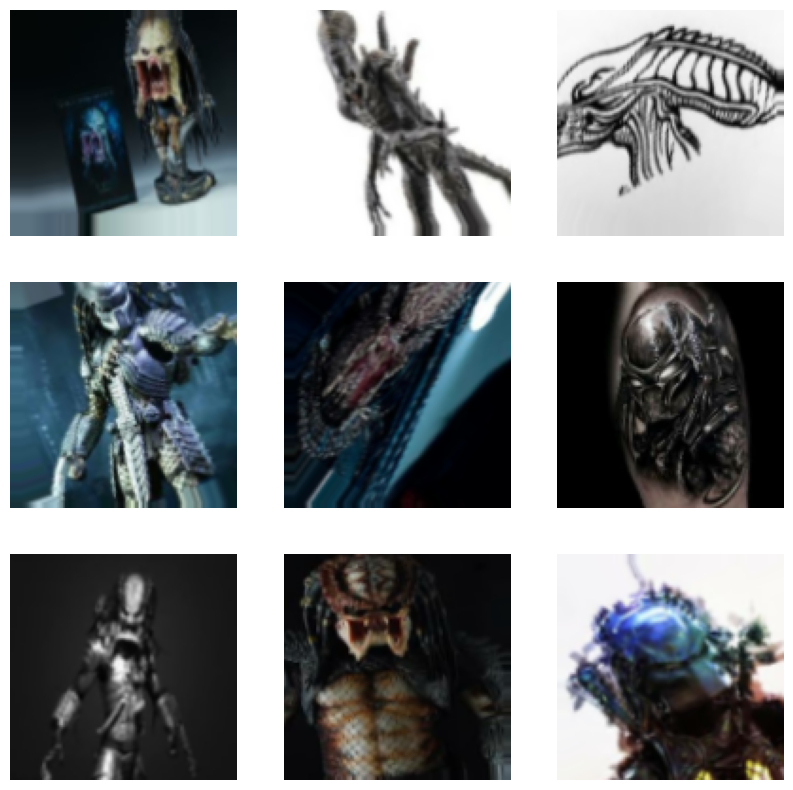

In [38]:
for images, labels in training_dataset.take(1):
    augmented_images = augmentation()(images)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

In [39]:
pre_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
for layer in pre_model.layers:
    layer.trainable = False

In [40]:
def create_model():
  augmentation_layers = augmentation()

  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=(120, 120, 3)),
      augmentation_layers,
      tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )

  return model

In [41]:
model = create_model()

history = model.fit(
	training_dataset,
	epochs=15,
	validation_data=validation_dataset,
)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5195 - loss: 0.6930 - val_accuracy: 0.6050 - val_loss: 0.6776
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6357 - loss: 0.6715 - val_accuracy: 0.6100 - val_loss: 0.6416
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6711 - loss: 0.6131 - val_accuracy: 0.6000 - val_loss: 0.6412
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7120 - loss: 0.5713 - val_accuracy: 0.5350 - val_loss: 0.8854
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6785 - loss: 0.6016 - val_accuracy: 0.5800 - val_loss: 0.7901
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7435 - loss: 0.5488 - val_accuracy: 0.6350 - val_loss: 0.6121
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7312 - loss: 0.5244 - val_accuracy: 0.6450 - val_loss: 0.6450
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7458 - loss: 0.5402 - val_accuracy: 0.6550 - val_loss:

In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.describe()

,accuracy,loss,val_accuracy,val_loss,epoch
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.714299,0.559864,0.620000,0.696315,7.000000
std,0.054667,0.054542,0.035857,0.091413,4.472136
min,0.561080,0.501222,0.535000,0.565088,0.000000
25%,0.703125,0.528967,0.600000,0.641389,3.500000
50%,0.728693,0.549102,0.630000,0.663275,7.000000
75%,0.745739,0.573404,0.642500,0.760631,10.500000
max,0.765625,0.689287,0.675000,0.885445,14.000000


In [43]:
class_names = ['alien', 'predator']

def plot_prediction(dataset, model, n_images):
    images, labels = next(iter(dataset))
    predictions = np.argmax(model.predict(images), axis=1)
    labels = labels.numpy().astype('int32')
    plt.figure(figsize=(14, 15))
    i = 0
    for image, label, prediction in zip(images, labels, predictions):
        if i >= n_images:
            break
        plt.subplot(4, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        if prediction == label:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r')
        plt.axis('off')
        i += 1

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


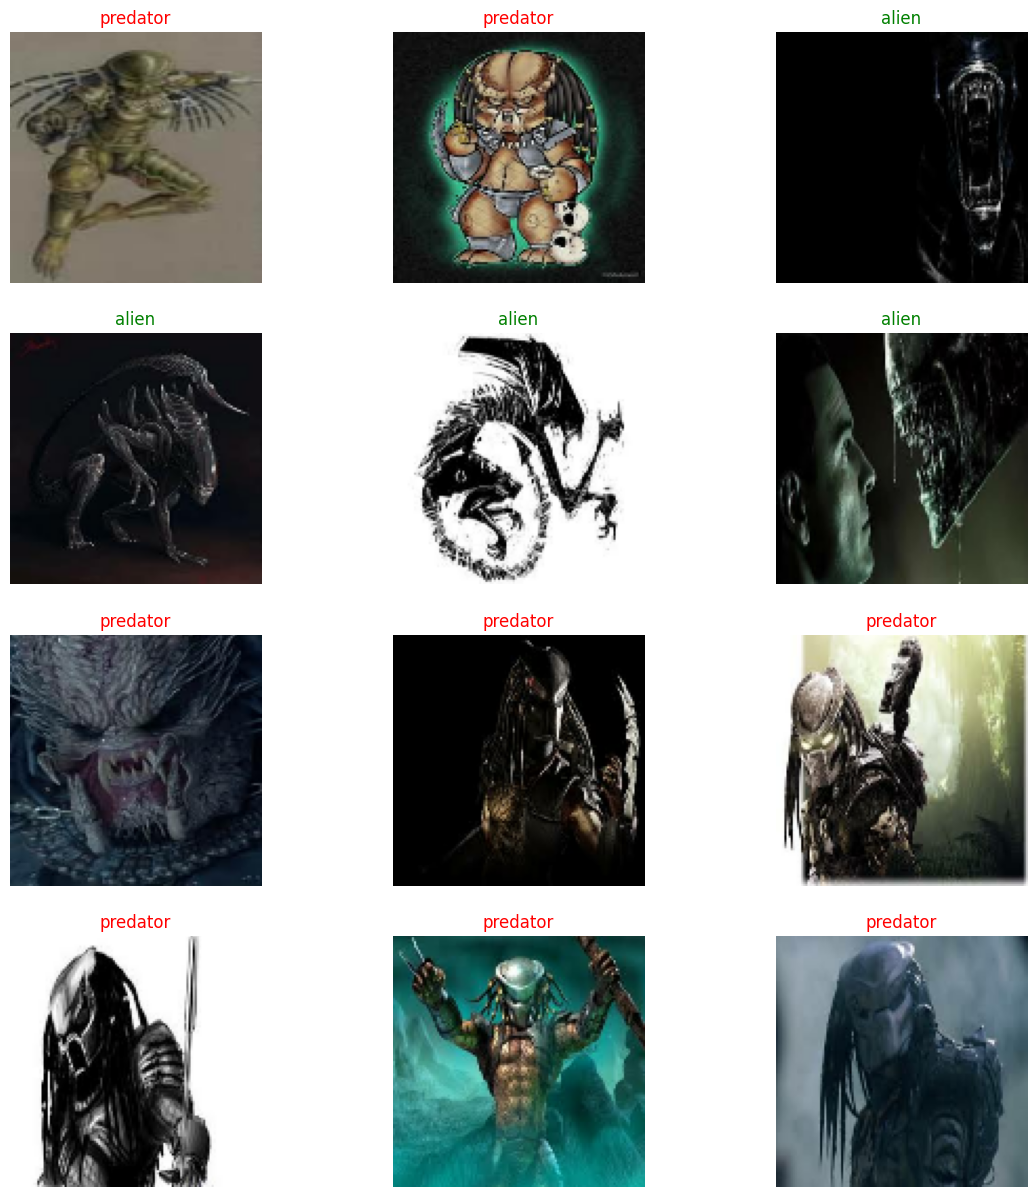

In [44]:
plot_prediction(validation_dataset, model, n_images=12)

In [45]:
test_predictions = model.predict(validation_dataset)

true_labels = []
for images, labels in validation_dataset:
    true_labels.extend(labels.numpy())

class_names = validation_dataset.class_names

predictions = np.argmax(test_predictions, axis=1)

from sklearn.metrics import accuracy_score
test_acc = accuracy_score(true_labels, predictions)

eval_results = model.evaluate(validation_dataset)

print(f'Loss: {eval_results[0]:.2f} - Accuracy: {eval_results[1] * 100:.2f}%')

print(f'Test accuracy: {test_acc:.2%}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.6453 - loss: 0.7717
Loss: 0.81 - Accuracy: 60.00%
Test accuracy: 50.00%


In [46]:
import pickle

with open('Transfer_Learning_RESNET50.pkl', 'wb') as file:
    pickle.dump(model, file)